# Train Stations Notebook

We want to find the minimal amount of transfers between two MTA stations which we can eventually reapply into an app n the future. We can do this via: http://web.mta.info/developers/data/nyct/subway/Stations.csv

The main parts of the csv file we may need to use are the station ID, division, stop name and daytime routes. We need to create a graph which connects the subway stations together so we can use breadth-first search to find the shortest route between the two routes.

In [1]:
import pandas as pd
from collections import deque, defaultdict
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 50, 50
%matplotlib inline

In [2]:
dq = deque()
dataset = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')

In [3]:
dq

deque([])

In [4]:
dataset.head(5)

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575


In [5]:
for index, row in dataset.iterrows():
    if row['Line'] == 'Franklin Ave Shuttle':
        dataset.at[index, "Daytime Routes"] = 'Fr_S'
    elif row['Line'] == 'Lexington - Shuttle':
        dataset.at[index, 'Daytime Routes'] = 'Lex_S'

dataset = dataset.iloc[:len(dataset)-1]

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
396,395,395,624,IRT,Lexington Av,103 St,M,6,Subway,40.790600,-73.947478
397,396,396,625,IRT,Lexington Av,96 St,M,6,Subway,40.785672,-73.951070
398,397,397,626,IRT,Lexington Av,86 St,M,4 5 6,Subway,40.779492,-73.955589
399,398,398,627,IRT,Lexington Av,77 St,M,6,Subway,40.773620,-73.959874
400,399,399,628,IRT,Lexington Av,68 St - Hunter College,M,6,Subway,40.768141,-73.963870
401,400,613,629,IRT,Lexington Av,59 St,M,4 5 6,Subway,40.762526,-73.967967
402,401,612,630,IRT,Lexington Av,51 St,M,6,Subway,40.757107,-73.971920
403,402,610,631,IRT,Lexington Av,Grand Central - 42 St,M,4 5 6,Subway,40.751776,-73.976848
404,403,403,632,IRT,Lexington Av,33 St,M,6,Subway,40.746081,-73.982076
405,404,404,633,IRT,Lexington Av,28 St,M,6,Subway,40.743070,-73.984264


In [6]:
kstops = dataset.drop(['Complex ID', 'Division', 'GTFS Stop ID', 'Borough', 'Structure'], axis=1)
kstops.rename(index=str,columns={"GTFS Latitude" : "Lat", 'GTFS Longitude': "Long", "Station ID": "id"}, inplace=True)
kstops.head(20)

,id,Line,Stop Name,Daytime Routes,Lat,Long
0,1,Astoria,Astoria - Ditmars Blvd,N W,40.775036,-73.912034
1,2,Astoria,Astoria Blvd,N W,40.770258,-73.917843
2,3,Astoria,30 Av,N W,40.766779,-73.921479
3,4,Astoria,Broadway,N W,40.761820,-73.925508
4,5,Astoria,36 Av,N W,40.756804,-73.929575
5,6,Astoria,39 Av,N W,40.752882,-73.932755
6,7,Astoria,Lexington Av/59 St,N W R,40.762660,-73.967258
7,8,Astoria,5 Av/59 St,N W R,40.764811,-73.973347
8,9,Broadway - Brighton,57 St - 7 Av,N Q R W,40.764664,-73.980658
9,10,Broadway - Brighton,49 St,N R W,40.759901,-73.984139


In [7]:
trains_stops = kstops[['Stop Name', 'Daytime Routes']]
trains_stops

,Stop Name,Daytime Routes
0,Astoria - Ditmars Blvd,N W
1,Astoria Blvd,N W
2,30 Av,N W
3,Broadway,N W
4,36 Av,N W
5,39 Av,N W
6,Lexington Av/59 St,N W R
7,5 Av/59 St,N W R
8,57 St - 7 Av,N Q R W
9,49 St,N R W


In [13]:
# Split the trains individually and gather them
nyc_trains = []

trains = trains_stops['Daytime Routes']
for many_trains in trains: # For the N W in the columns
    train_list = many_trains.split(" ") # Split the N W into ['N', 'W']
    for train in train_list: # For each char in ['N', 'W']
        nyc_trains.append(train) # add it to the list

nyc_trains = sorted(list(set(nyc_trains)))
print(nyc_trains)

['1', '2', '3', '4', '42nd', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'SIR', 'St', 'W', 'Z']


In [14]:
for index, row in trains_stops.iterrows():
    print(index, row['Stop Name'], row['Daytime Routes'])

0 Astoria - Ditmars Blvd N W
1 Astoria Blvd N W
2 30 Av N W
3 Broadway N W
4 36 Av N W
5 39 Av N W
6 Lexington Av/59 St N W R
7 5 Av/59 St N W R
8 57 St - 7 Av N Q R W
9 49 St N R W
10 Times Sq - 42 St N Q R W
11 34 St - Herald Sq N Q R W
12 28 St R W
13 23 St R W
14 14 St - Union Sq N Q R W
15 8 St - NYU R W
16 Prince St R W
17 Canal St R W
18 Canal St N Q
19 City Hall R W
20 Cortlandt St R W
21 Rector St R W
22 Whitehall St R W
23 Court St R
24 Jay St - MetroTech R
25 DeKalb Av B Q R
26 Atlantic Av - Barclays Ctr D N R
27 Union St R
28 9 St R
29 Prospect Av R
30 25 St R
31 36 St D N R
32 45 St R
33 53 St R
34 59 St N R
35 Bay Ridge Av R
36 77 St R
37 86 St R
38 Bay Ridge - 95 St R
39 Atlantic Av - Barclays Ctr B Q
40 7 Av B Q
41 Prospect Park B Q
42 Parkside Av B Q
43 Church Av B Q
44 Beverley Rd B Q
45 Cortelyou Rd B Q
46 Newkirk Plaza B Q
47 Avenue H B Q
48 Avenue J B Q
49 Avenue M B Q
50 Kings Hwy B Q
51 Avenue U B Q
52 Neck Rd B Q
53 Sheepshead Bay B Q
54 Brighton Beach B Q
55 Oc

495 Tottenville SIR


In [15]:
# Gather all the stops made by a single train
train_to_stops = defaultdict(list)
for train in nyc_trains:
    for index, row in trains_stops.iterrows():
        if train in row['Daytime Routes'].split(" "):
            train_to_stops[train] += [row['Stop Name']]
train_to_stops

defaultdict(list,
            {'1': ['Van Cortlandt Park - 242 St',
              '238 St',
              '231 St',
              'Marble Hill - 225 St',
              '215 St',
              '207 St',
              'Dyckman St',
              '191 St',
              '181 St',
              '168 St - Washington Hts',
              '157 St',
              '145 St',
              '137 St - City College',
              '125 St',
              '116 St - Columbia University',
              'Cathedral Pkwy',
              '103 St',
              '96 St',
              '86 St',
              '79 St',
              '72 St',
              '66 St - Lincoln Center',
              '59 St - Columbus Circle',
              '50 St',
              'Times Sq - 42 St',
              '34 St - Penn Station',
              '28 St',
              '23 St',
              '18 St',
              '14 St',
              'Christopher St - Sheridan Sq',
              'Houston St',
              'Canal St',
        

In [47]:
stops = trains_stops['Stop Name']
stops_to_transfers = defaultdict(list)

for index, row in trains_stops.iterrows():
    stops_to_transfers[row['Stop Name']] += []

stops_to_transfers

defaultdict(list,
            {'Astoria - Ditmars Blvd': [],
             'Astoria Blvd': [],
             '30 Av': [],
             'Broadway': [],
             '36 Av': [],
             '39 Av': [],
             'Lexington Av/59 St': [],
             '5 Av/59 St': [],
             '57 St - 7 Av': [],
             '49 St': [],
             'Times Sq - 42 St': [],
             '34 St - Herald Sq': [],
             '28 St': [],
             '23 St': [],
             '14 St - Union Sq': [],
             '8 St - NYU': [],
             'Prince St': [],
             'Canal St': [],
             'City Hall': [],
             'Cortlandt St': [],
             'Rector St': [],
             'Whitehall St': [],
             'Court St': [],
             'Jay St - MetroTech': [],
             'DeKalb Av': [],
             'Atlantic Av - Barclays Ctr': [],
             'Union St': [],
             '9 St': [],
             'Prospect Av': [],
             '25 St': [],
             '36 St': [],
       

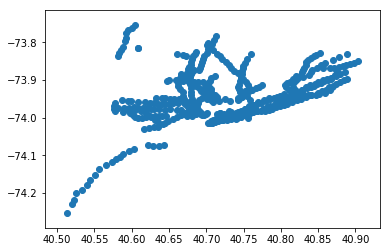

In [11]:
plt.scatter(kstops['Lat'], kstops['Long'])